# Такси - Датапарк

### Описание кейса

**Проблема сервиса:** Заказы поступают без остановки, но водителей не хватает. Система назначения буксует: одни клиенты ждут слишком долго, другие отменяют поездку. Чтобы повысить назначаемость водителей команда таксопарка запустила продуктовый эксперимент с тестированием эффективности расширения радиуса.     
**Условие A/B-теста:** Половина заказов осталась с привычным радиусом поиска в 3 км, а вторая половина получила расширенный радиус — 5 км.
Заказы определялись в группы рандомным образом.     
**Гипотеза:** Чем шире радиус, тем выше шанс найти водителя. Но риск очевиден - слишком дальняя подача может испортить пользовательский опыт.    

**А/В-эксперимент**

Заказы пользователей в течение недели случайным образом разделили на две равные группы: 
- Контрольная группа - радиус поиска 3 км.
- Тестовая группа - радиус поиска 5 км.

Чтобы увидеть полную картину выберем для эксперимента такой набор метрик: 
- Ключевая метрика — конверсии из _order_ в _assign_.
- Барьерная метрика — конверсии из _assign_ в _arrive_ (необходимо следить, чтобы дальняя подача машины не привела к отмене заказа после назначения водителя).
- Вспомогательная метрика 1 — среднее времени назначения водителя на заказ.
- Вспомогательная метрика 2 — конверсия из _order_ в _trip_.

Ожидалось, что ключевая и вспомогательная метрика 2 покажут рост, барьерная метрика и вспомогательная метрика 1  не упадут.

### Задачи аналитика

- Убедиться, что сплит-система А/В-теста работает работает верно и разбирает заказы 50/50;     
- Провести полный анализ результатов А/В-эксперимента;
- Предложить способ определять отложенные заказы и исследовать их влияние на результаты А/В-теста.

### Данные

Датасет `delo_datapark.csv` содержит данные А/В-эксперимента — идентификатор и временные данные заказа. Пользователи уже распределены по группам А/В-эксперимента.

- `id_order` — уникальный идентификатор заказа.;
- `test_group` — флаг, относящий заказ к контрольной или тестовой группе;
- `time_order` — дата + время создания заказа;
- `time_offer` — дата + время первого предложения заказа водителю;
- `time_assign` — дата + время согласия и назначения водителя на заказ;
- `time_arrive` — дата + время прибытия водителя в точку «А»;
- `trip_time` — дата + время успешного окончания поездки в точке «В».

### План проекта

1. Загрузка данных и их предобработка;
2. Исследовательский анализ отложенных заказов и их влияния на результаты А/В-теста;
3. Исследование изменения метрик;
4. Анализ результатов А/В эксперимента;
5. Выводы.

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [42]:
datapark_df = pd.read_csv('delo_datapark.csv', sep=';', header = 1)

In [43]:
datapark_df.head(10)

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,10001.0,0.0,04.3.2024 0:00:01,04.3.2024 0:00:42,04.3.2024 0:01:13,04.3.2024 0:09:07,04.3.2024 1:27:28
1,10002.0,0.0,04.3.2024 0:00:22,04.3.2024 0:01:00,04.3.2024 0:01:14,04.3.2024 0:08:45,04.3.2024 0:22:22
2,10003.0,1.0,04.3.2024 0:07:08,04.3.2024 0:07:44,NaN,NaN,NaN
3,10004.0,1.0,04.3.2024 0:07:11,04.3.2024 0:08:21,04.3.2024 0:08:46,04.3.2024 0:21:13,04.3.2024 1:23:25
4,10005.0,0.0,04.3.2024 0:11:59,04.3.2024 0:12:50,04.3.2024 0:13:09,04.3.2024 0:21:43,04.3.2024 0:46:45
5,10006.0,1.0,04.3.2024 0:32:12,04.3.2024 0:32:49,04.3.2024 0:33:19,NaN,NaN
6,10007.0,1.0,04.3.2024 0:33:56,04.3.2024 0:35:12,04.3.2024 0:35:33,04.3.2024 0:39:06,04.3.2024 1:38:21
7,10008.0,0.0,04.3.2024 0:39:49,04.3.2024 0:40:24,04.3.2024 0:40:54,04.3.2024 0:42:57,04.3.2024 1:48:37
8,10009.0,0.0,04.3.2024 0:44:29,04.3.2024 0:45:33,04.3.2024 0:46:03,04.3.2024 0:47:02,04.3.2024 1:16:10
9,10010.0,1.0,04.3.2024 0:52:33,04.3.2024 0:53:42,04.3.2024 0:54:07,NaN,NaN


In [44]:
datapark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12282 entries, 0 to 12281
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_order     12281 non-null  float64
 1   test_group   12281 non-null  float64
 2   time_order   12281 non-null  object 
 3   time_offer   10781 non-null  object 
 4   time_assign  9624 non-null   object 
 5   time_arrive  7724 non-null   object 
 6   trip_time    7384 non-null   object 
dtypes: float64(2), object(5)
memory usage: 671.8+ KB


In [45]:
# Изучим пропуск в столбце 'id_order'

In [46]:
na = datapark_df[datapark_df['id_order'].isna()]
display(na)

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
12281,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Удалим пустой пропуск в столбце 'id_order'

In [48]:
datapark_df = datapark_df.dropna(subset = 'id_order')

In [49]:
# Переведем значения в столбце 'id_order' и 'test_group' к целочисленному виду

In [50]:
datapark_df['id_order'] = datapark_df['id_order'].astype('int')
datapark_df['test_group'] = datapark_df['test_group'].astype('int')

In [51]:
# Проверим число дубликатов

In [52]:
num_duplicates = datapark_df.duplicated().sum()
print(f'Число явных дубликатов в файле {num_duplicates}')

Число явных дубликатов в файле 0


In [53]:
# Находим пересечения пользователей по тестовым группам

In [54]:
flawed_users = datapark_df.groupby('id_order')['test_group'].nunique().reset_index(name = 'count_of_group')

In [55]:
flawed_users = flawed_users[flawed_users['count_of_group'] > 1]

In [56]:
display(flawed_users)

,id_order,count_of_group


Вывод: пересечений по группам пользователей нет

In [57]:
# Найдем количество пользователей в каждой группе 

In [58]:
count_per_group = datapark_df.groupby('test_group')['id_order'].nunique().reset_index(name = 'orders_in_group')
count_per_group['share_of_group'] = round(count_per_group['orders_in_group']/(count_per_group['orders_in_group'].sum())*100)

In [59]:
display(count_per_group)

,test_group,orders_in_group,share_of_group
0,0,5684,46.0
1,1,6597,54.0


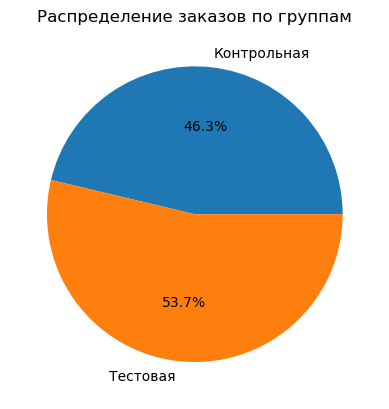

In [101]:
labels = ['Контрольная', 'Тестовая']

count_per_group.plot(kind = 'pie', y = 'orders_in_group', labels = labels, legend = False, autopct = '%1.1f%%')

plt.title('Распределение заказов по группам')
plt.ylabel('')
plt.show()

Вывод: распределение в контрольной и тестовой группе 54/46.

In [60]:
# Переведем значения временных стоблцов к соотвествующему виду

In [61]:
list_column = ['time_order', 'time_offer', 'time_assign', 'time_arrive', 'trip_time']

for i in list_column:
    datapark_df[i] = pd.to_datetime(datapark_df[i], errors='coerce')

In [62]:
datapark_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12281 entries, 0 to 12280
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_order     12281 non-null  int64         
 1   test_group   12281 non-null  int64         
 2   time_order   12281 non-null  datetime64[ns]
 3   time_offer   10781 non-null  datetime64[ns]
 4   time_assign  9599 non-null   datetime64[ns]
 5   time_arrive  7703 non-null   datetime64[ns]
 6   trip_time    7366 non-null   datetime64[ns]
dtypes: datetime64[ns](5), int64(2)
memory usage: 767.6 KB


In [63]:
print(datapark_df['time_order'].min())
print(datapark_df['time_order'].max())

2024-04-03 00:00:01
2024-10-03 23:45:48


### Исследуем время от оформления заказа до момента назначения водителя на заказ и до момента подачи машины¶

In [64]:
# Посчитаем время от оформления заказа до момента назначения водителя на заказ и до момента подачи машины

In [65]:
datapark_df['time_before_assign'] = (datapark_df['time_assign'] - datapark_df['time_order']).dt.total_seconds()/60

In [66]:
datapark_df['time_before_arrive'] = (datapark_df['time_arrive'] - datapark_df['time_order']).dt.total_seconds()/60

In [67]:
# Посчитаем среднее время от оформления заказа до момента назначения водителя на заказ и до момента подачи машины в обеих группах

In [68]:
mean_time = datapark_df.groupby('test_group').agg({
    'time_before_assign': 'mean',
    'time_before_arrive': 'mean'
})

In [69]:
display(round(mean_time, 2))

,time_before_assign,time_before_arrive
test_group,,
0,31.51,112.96
1,11835.15,10987.63


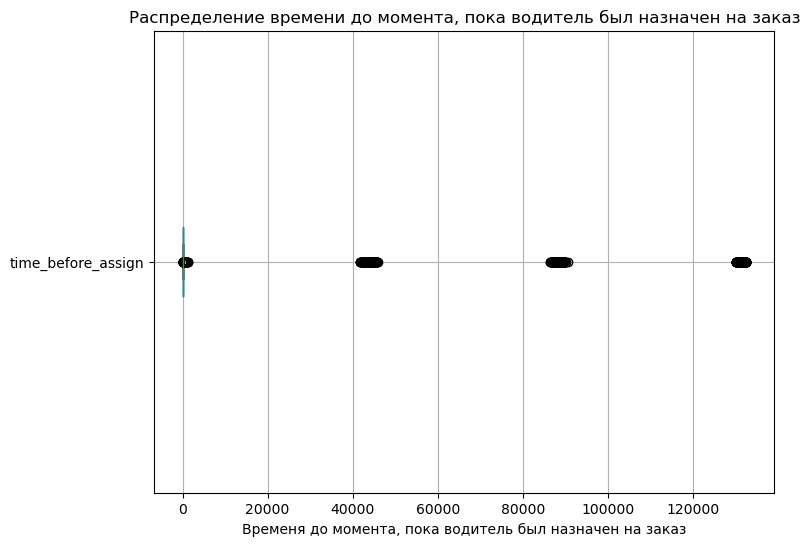

In [70]:
# Исследуем распределение времени до момента, пока водитель был назначен на заказ
plt.figure(figsize=(8, 6))

boxplot_1 = datapark_df.boxplot(column = 'time_before_assign',
                                  vert = False, 
                                  figsize=(10, 6))

boxplot_1.set_title('Распределение времени до момента, пока водитель был назначен на заказ')
boxplot_1.set_xlabel('Временя до момента, пока водитель был назначен на заказ')

plt.show()

In [71]:
datapark_df_cut = datapark_df[(datapark_df['time_before_assign'] <= 200)]

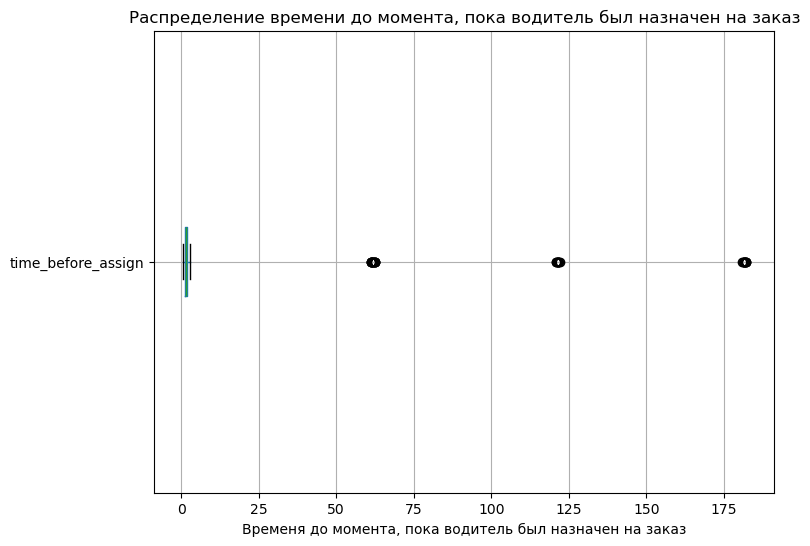

In [72]:
# Исследуем распределение времени до момента, пока водитель был назначен на заказ еще раз
plt.figure(figsize=(8, 6))

boxplot_2 = datapark_df_cut.boxplot(column = 'time_before_assign',
                                  vert = False, 
                                  figsize=(10, 6))

boxplot_2.set_title('Распределение времени до момента, пока водитель был назначен на заказ')
boxplot_2.set_xlabel('Временя до момента, пока водитель был назначен на заказ')

plt.show()

Вывод: можно считать, что если для заказа время от оформления заказа до момента, пока водитель был назначен на заказ меньше 50 минут - это отложенный заказ.

In [73]:
datapark_df_cut = datapark_df[datapark_df['time_before_assign'] < 50]

In [74]:
mean_time_cut = datapark_df_cut.groupby('test_group').agg({
    'time_before_assign': 'mean',
    'time_before_arrive': 'mean'
})

In [75]:
display(round(mean_time_cut, 2))

,time_before_assign,time_before_arrive
test_group,,
0,1.60,78.28
1,1.62,98.10


Вывод: без поправки на отложенные заказы временные значения в тестовой группе сильно завышены по сравнению с контрольной группой.

In [76]:
datapark_df_short = datapark_df[datapark_df['time_before_assign'] < 50]
datapark_df_long = datapark_df[datapark_df['time_before_assign'] >= 50]

short_group = datapark_df_short.groupby('test_group')['id_order'].count().reset_index()
long_group = datapark_df_long.groupby('test_group')['id_order'].count().reset_index()

In [77]:
display(short_group)
display(long_group)

,test_group,id_order
0,0,4282
1,1,4417


,test_group,id_order
0,0,3
1,1,897


Вывод: контрольная и тестовые группы не равназначны по количеству отложенных заказов, что может отрицательно сказаься на результатах теста, так как клиенты с отложенным заказом будут менее чувствительны в более долгому ожиданию машины.

### Исследуем изменение метрик

In [78]:
# Создадим столбец, отражающий статус, в котором закончился заказ

In [79]:
def status_func(x):
    if pd.isna(x['time_offer']):
        return 'order'
    elif pd.isna(x['time_assign']):
        return 'offer' 
    elif pd.isna(x['time_arrive']):
        return 'assign'    
    elif pd.isna(x['trip_time']):
        return 'arrive'        
    else:
        return 'trip'

datapark_df['status'] = datapark_df.apply(status_func, axis=1)

In [80]:
display(datapark_df)

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,time_before_assign,time_before_arrive,status
0,10001,0,2024-04-03 00:00:01,2024-04-03 00:00:42,2024-04-03 00:01:13,2024-04-03 00:09:07,2024-04-03 01:27:28,1.200000,9.100000,trip
1,10002,0,2024-04-03 00:00:22,2024-04-03 00:01:00,2024-04-03 00:01:14,2024-04-03 00:08:45,2024-04-03 00:22:22,0.866667,8.383333,trip
2,10003,1,2024-04-03 00:07:08,2024-04-03 00:07:44,NaT,NaT,NaT,NaN,NaN,offer
3,10004,1,2024-04-03 00:07:11,2024-04-03 00:08:21,2024-04-03 00:08:46,2024-04-03 00:21:13,2024-04-03 01:23:25,1.583333,14.033333,trip
4,10005,0,2024-04-03 00:11:59,2024-04-03 00:12:50,2024-04-03 00:13:09,2024-04-03 00:21:43,2024-04-03 00:46:45,1.166667,9.733333,trip
...,...,...,...,...,...,...,...,...,...,...
12276,22293,0,2024-08-03 18:45:00,2024-08-03 18:46:21,2024-08-03 18:46:56,NaT,NaT,1.933333,NaN,assign
12277,22294,0,2024-08-03 18:26:51,2024-08-03 18:28:04,2024-08-03 18:28:31,NaT,NaT,1.666667,NaN,assign
12278,22295,1,2024-08-03 18:58:33,2024-08-03 18:59:46,2024-08-03 19:00:23,2024-08-03 19:08:35,2024-08-03 19:22:24,1.833333,10.033333,trip
12279,22296,0,2024-08-03 18:47:16,2024-08-03 18:48:49,2024-08-03 18:49:09,2024-08-03 18:53:32,2024-08-03 19:31:03,1.883333,6.266667,trip


In [81]:
# Зададим шаги воронки от конца к началу

In [82]:
funnel_steps = ['trip', 'arrive', 'assign', 'offer', 'order']
test_group_list = [0, 1]

In [83]:
# Создадим датафреймы с конверсией для контрольной и тестовой группы

In [84]:
status_0 = []
status_1 = []

In [85]:
df_list = [status_0, status_1]

In [86]:
# Зададим шаги воронки от начала к концу
new_funnel_steps = funnel_steps[::-1]

In [87]:
for group, df in zip(test_group_list, df_list):
    datapark_df_filter = datapark_df[datapark_df['test_group'] == group]
    
    status = datapark_df_filter.groupby('status')['id_order'].count().reindex(funnel_steps).fillna(0)
    status = status.cumsum()
    status_df = status.reindex(new_funnel_steps).reset_index(name = 'count_all_order')

    status_df['conversation'] = round(status_df['count_all_order']/status_df['count_all_order'][0] * 100, 2)
    status_df['conversation_from_previos_step'] = round(status_df['count_all_order']/status_df['count_all_order'].shift(1) * 100, 2)
  
    display(status_df)
  
    df.append(status_df)

,status,count_all_order,conversation,conversation_from_previos_step
0,order,5684,100.00,NaN
1,offer,4846,85.26,85.26
2,assign,4285,75.39,88.42
3,arrive,3689,64.90,86.09
4,trip,3562,62.67,96.56


,status,count_all_order,conversation,conversation_from_previos_step
0,order,6597,100.00,NaN
1,offer,5935,89.97,89.97
2,assign,5314,80.55,89.54
3,arrive,4014,60.85,75.54
4,trip,3804,57.66,94.77


In [88]:
status_df_0 = pd.concat(status_0)
status_df_1 = pd.concat(status_1)

In [89]:
# Визуализируем воронки

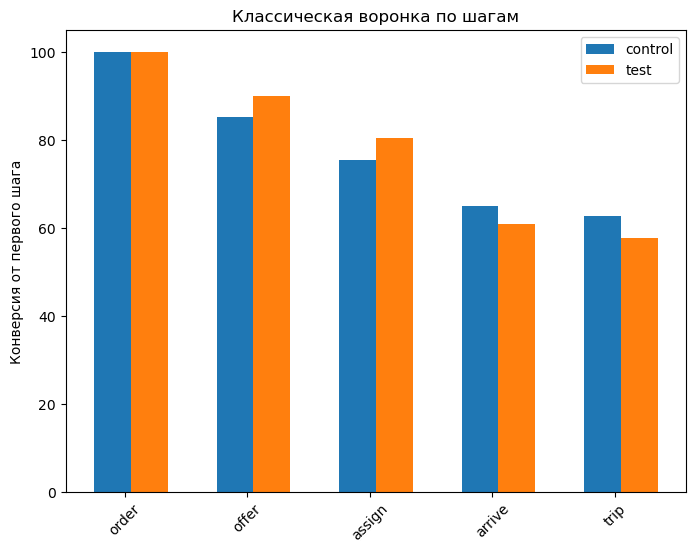

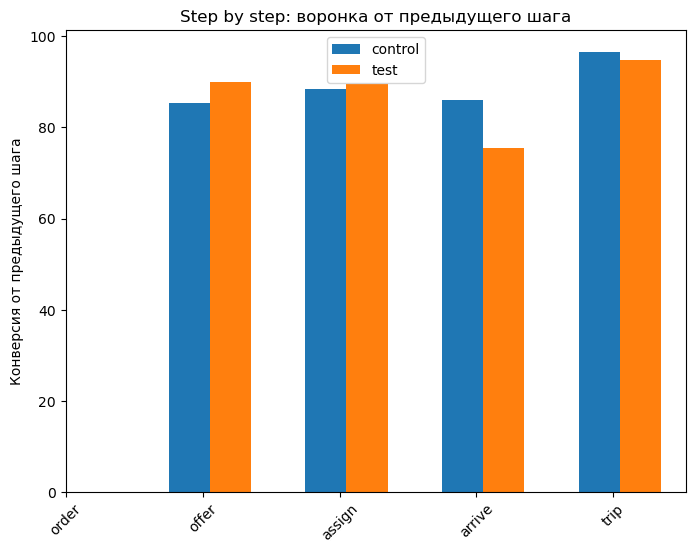

In [90]:
columns = ['conversation', 'conversation_from_previos_step']
titles=['Классическая воронка по шагам', 
        'Step by step: воронка от предыдущего шага']
ylabels=['Конверсия от первого шага', 
         'Конверсия от предыдущего шага']

for column, title, ylabel in zip(columns, titles, ylabels):
    
    plt.figure(figsize=(8, 6))
    index = np.arange(len(new_funnel_steps))
    bw = 0.3
    
    plt.bar(index, status_df_0[column], bw, label = 'control')
    plt.bar(index+bw, status_df_1[column], bw, label = 'test')
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(index+0.1, new_funnel_steps, rotation = 45)
    plt.legend()
    plt.show

In [91]:
# Посчитаем количество заказов в каждом статусе для контрольной и тестовой группе

In [92]:
trip_in_status = datapark_df.groupby('status')['test_group'].value_counts().unstack(fill_value = 0).reindex(new_funnel_steps)

In [93]:
display(trip_in_status)

test_group,0,1
status,,
order,838,662
offer,561,621
assign,596,1300
arrive,127,210
trip,3562,3804


### Исследуем изменение ключевой метрики - Исследование результатов А/В эксперимента

- Гипотезы для проверки:
- Конверсия из `order` в `assign` в контрольной и тестовой группах одинаковы.
   - H_0: conversion_control = conversion_test 
- Конверсия из `order` в `assign` в контрольной группе меньше, чем в тестовой.
   - H_1: conversion_control < conversion_test
 
Так как ключевая метрика - метрика, выраженная в долях, для проверки статистической значимости изменения выбираем Z-тест пропорций.

In [94]:
abs_delta_conversion = status_df_1['conversation'][2] - status_df_0['conversation'][2]
rel_delta_conversion = (status_df_1['conversation'][2] - status_df_0['conversation'][2])/status_df_0['conversation'][2]*100
print(f'Абсолютное изменение значений в тестовой группе по сравнению с контрольной  {abs_delta_conversion:.2f}, относительное  {rel_delta_conversion:.2f}%')

Абсолютное изменение значений в тестовой группе по сравнению с контрольной  5.16, относительное  6.84%


In [95]:
# Общее число пользователей в каждой группе на этапе `order`
n_control = status_df_0['count_all_order'][4]
n_test = status_df_1['count_all_order'][4]
# Число успехов - количество пользователей в каждой группе на этапе `assign`
m_control = status_df_0['count_all_order'][2]
m_test = status_df_1['count_all_order'][2]
# Вероятность успеха в каждой группе
p_control = status_df_0['conversation'][2]/100
p_test = status_df_1['conversation'][2]/100

In [96]:
#Проверяем предпосылку о достаточном количестве данных
if (p_control*n_control>10) and ((1-p_control)*n_control>10) and (p_test*n_test>10) and ((1-p_test)*n_test>10):
    print(f'Предпосылка о достаточном количестве данных выполняется!')
else:
    print(f'Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [97]:
#Проводим Z-тест пропроций   
alpha = 0.05
    
stat_ztest, p_value_ztest = proportions_ztest(
        [m_control, m_test],
        [n_control, n_test],
        alternative='smaller' 
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print(f'Конверсия из оформления заказа в назначение водителя на поездку в тестовых группах не изменилась по сравнению с контрольной группой')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print(f'Конверсия из оформления заказа в назначение водителя на поездку в тестовых группах улучшилась по сравнению с контрольной группой')

pvalue=nan < 0.05
Конверсия из оформления заказа в назначение водителя на поездку в тестовых группах улучшилась по сравнению с контрольной группой


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/stats/proportion.py:1024: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


### Исследуем изменение барьерной метрики - конверсии из _assign_ в _arrive_

In [98]:
abs_delta_conversion_from_assign_to_arrive = (status_df_1['conversation_from_previos_step'][3] - 
                                               status_df_0['conversation_from_previos_step'][3])
rel_delta_conversion_from_assign_to_arrive = (status_df_1['conversation_from_previos_step'][3] - 
                        status_df_0['conversation_from_previos_step'][3])/status_df_0['conversation_from_previos_step'][3]*100
print(f'Абсолютное изменение значений в тестовой группе по сравнению с контрольной  {abs_delta_conversion_from_assign_to_arrive:.2f}, относительное  {rel_delta_conversion_from_assign_to_arrive:.2f}%')

Абсолютное изменение значений в тестовой группе по сравнению с контрольной  -10.55, относительное  -12.25%


### Исследуем изменение первой вспомогательной метрики - среднего времени назначения водителя на заказ

In [99]:
abs_delta_mean_time = (mean_time_cut['time_before_assign'][1] - 
                                               mean_time_cut['time_before_assign'][0])
rel_delta_mean_time = (mean_time_cut['time_before_assign'][1] - 
                        mean_time_cut['time_before_assign'][0])/mean_time_cut['time_before_assign'][0]*100
print(f'Абсолютное изменение значений в тестовой группе по сравнению с контрольной  {abs_delta_mean_time:.2f}, относительное  {rel_delta_mean_time:.2f}%')

Абсолютное изменение значений в тестовой группе по сравнению с контрольной  0.02, относительное  1.30%


### Исследуем изменение второй вспомогательной метрики - конверсии из _order_ в _trip_

In [100]:
abs_delta_conversion_to_trip = status_df_1['conversation'][4] - status_df_0['conversation'][4]
rel_delta_conversion_to_trip = (status_df_1['conversation'][4] - status_df_0['conversation'][4])/status_df_0['conversation'][4]*100
print(f'Абсолютное изменение значений в тестовой группе по сравнению с контрольной  {abs_delta_conversion_to_trip:.2f}, относительное  {rel_delta_conversion_to_trip:.2f}%')

Абсолютное изменение значений в тестовой группе по сравнению с контрольной  -5.01, относительное  -7.99%


#### Выводы

- Сплит-система А/В-теста работает работает корректно, разбиение заказов в данном тесте 54/46, однако в тестовой группе практически в 300 раз больше отложенных заказов, что может отрицательно сказаться на достоверности результатов теста, так как клиенты с отложенным заказом будут менее чувствительны к более долгому ожиданию машины.
- Абсолютное изменение значения конверсии из оформления заказа в назначение водителя на поездку в тестовой группе по сравнению с контрольной  5.16, относительное  6.84%, и это изменение статистически значимо, однако, конверсия из _assign_ в _arrive_ в тестовой группе снизилась на 12.25%, по сравнению с контрольной группой, что говорит о том, что более дальняя подача машины и увеличенное время ожидания увеличивают число отмен со стороны клиентов после назначения водителя.    
- Среднее времени назначения водителя на заказ не изменяется, при этом конверсии из _order_ в _trip_ в тестовой группе снизилась на 7.99% по сравнению с контрольной группой.
- Исходя из распределения времени от оформления заказа до момента назначения водителя на заказ, определено, что заказы с временем от _order_ до _assign_ более 50 минут относятся к отложенным заказам. Без поправки на отложенные заказы временные значения в тестовой группе сильно завышены по сравнению с контрольной группой.

#### Рекомендации

- При сплитовании стоит учитывать отложенные заказы и более равномерно распределять их по группам, во избежание искажения результатов. За качестве границы стоит ориентироваться на величину в 50 минут.         
- По результатам А/В-теста наблюдается статически значимое улучшение конверсии из оформления заказа в назначение водителя на поездку в тестовой группе, но уменьшается конверсия из _assign_ в _arrive_ и из _order_ в _trip_, таким образом запуск расширения радиуса поиска может привести к ухудшению пользовательского опыта и снижению общей выручки.